In [129]:
from functools import partial
import os
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import torch.nn.init as init
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import torchaudio   
from torchaudio.functional import edit_distance
from torchaudio.models.decoder import ctc_decoder
from tqdm import tqdm


In [130]:
AUDIO_FILES_DIR = Path('/mnt/c/Study/Python/Morse/morse_dataset')
CACHE_DIR = Path("/mnt/c/Study/Python/Morse/mel_cache")

train_df = pd.read_csv('/mnt/c/Study/Python/Morse/train.csv')
val_df = pd.read_csv('/mnt/c/Study/Python/Morse/val.csv')
test_df = pd.read_csv('/mnt/c/Study/Python/Morse/test.csv')

In [131]:
def get_vocab(words, blank= "<blk>"):
    vocab = {0: blank, 1: "|"}
    all_chars = set("".join(words.astype(str)))

    for i, char in enumerate(sorted(all_chars), start=2):
        vocab[i] = char

    print(f"Vocab is ready, size = {len(vocab)}")
    return vocab

In [132]:
full_vocab = get_vocab(train_df['message'])
print(full_vocab)

Vocab is ready, size = 46
{0: '<blk>', 1: '|', 2: ' ', 3: '#', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'А', 15: 'Б', 16: 'В', 17: 'Г', 18: 'Д', 19: 'Е', 20: 'Ж', 21: 'З', 22: 'И', 23: 'Й', 24: 'К', 25: 'Л', 26: 'М', 27: 'Н', 28: 'О', 29: 'П', 30: 'Р', 31: 'С', 32: 'Т', 33: 'У', 34: 'Ф', 35: 'Х', 36: 'Ц', 37: 'Ч', 38: 'Ш', 39: 'Щ', 40: 'Ъ', 41: 'Ы', 42: 'Ь', 43: 'Э', 44: 'Ю', 45: 'Я'}


In [133]:
class Tokenizer:
    def __init__(self, vocab):
        self.index_char = vocab
        self.char_index = {char: index for index, char in self.index_char.items()}
        
    def __call__(self, chars):
        return [self.char_index.get(char) for char in chars]
        
    def decode(self, indexs):
        return "".join([self.index_char.get(idx, "") for idx in indexs])

In [134]:
def decoding_to_tokens(decoder,model_output,tokenizer):
    
    log_probs = F.log_softmax(model_output, dim=-1) #[B, T, vocab_size]
    results = decoder(log_probs.contiguous())  

    decoded_sequences = []
    for batch_result in results:
        top_hypo = batch_result[0]
        tokens = top_hypo.tokens.tolist()
        decoded_sequence = tokenizer.decode(tokens)
        decoded_sequence = decoded_sequence.strip("|")
        decoded_sequences.append(decoded_sequence)

    return decoded_sequences

In [135]:
def loss_ctc(model_output,targets, target_lengths,blank_id= 0):
    
    log_output = F.log_softmax(model_output, dim=-1)
    log_output = log_output.transpose(0, 1)

    output_time_dim = log_output.shape[0]  
    batch_size = log_output.shape[1]  

    output_lengths = torch.full(size=(batch_size,), fill_value=output_time_dim, dtype=torch.long, device="cpu")
    
    targets_cpu = targets.cpu()
    target_lengths_cpu = target_lengths.cpu()

    loss = nn.CTCLoss(blank=blank_id, reduction="mean", zero_infinity=True)

    batch_loss = loss(log_output.float(), targets_cpu, output_lengths, target_lengths_cpu)
    return batch_loss

In [136]:
def dataloader_collate(batch):
    inputs = [item["input"].T for item in batch]  # [T, C]

    padded_inputs = pad_sequence(inputs, batch_first=True)  # [B, max_T, C]
    padded_inputs = padded_inputs.transpose(1, 2)  # [B, C, T]

    collated = {"input": padded_inputs}

    if "target" in batch[0]:
        targets = torch.cat([item["target"] for item in batch], dim=0)
        target_lengths = torch.tensor([item["target_length"] for item in batch], dtype=torch.long)
        collated["target_text"] = [item["target_text"] for item in batch]
        collated["target"] = targets
        collated["target_length"] = target_lengths

    return collated

In [137]:
class MorseDataset(Dataset):
    """
        X_filenames: Список путей к аудио файлам.
        y_texts: Список расшифровок.
        transform: Функция для преобразования аудио файлов в признаки.
        tokenizer: Tokenizer для преобразования текста в индексы.
    """

    def __init__(self, X_filenames, y_texts = None, transform = None, tokenizer=None):
        
        self.X_filenames = X_filenames.reset_index(drop=True)
        self.y_texts = y_texts.reset_index(drop=True) if y_texts is not None else None
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.X_filenames)

    def __getitem__(self, idx):
        filename = self.X_filenames[idx]
        mel_features = self.transform(filename)  

        item = {"input": torch.tensor(mel_features, dtype=torch.float)}

        if self.y_texts is not None:   
            text = self.y_texts[idx]
            target = self.tokenizer(text)

            item["target_text"] = text
            item["target"] = torch.tensor(target, dtype=torch.long)
            item["target_length"] = len(target)

        return item

In [138]:
def path_to_blackmel_cached(file_name,audio_files_dir,cache_dir,overwrite = False):
    cache_path = cache_dir / (file_name.replace(".wav", ".npy"))

    if cache_path.exists() and not overwrite:
        return np.load(cache_path)

    waveform, sr = torchaudio.load(audio_files_dir / file_name)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=512, hop_length=128, n_mels=64
    )(waveform)
    boost_mel = mel**8
    boost_mel = boost_mel / boost_mel.max()
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=64)(boost_mel)
    mel_db = mel_db.squeeze(0).cpu().numpy()

    peak = np.argmax(mel_db.mean(axis=1))
    start = max(peak - 10, 0)
    end = min(peak + 10, mel_db.shape[0])
    fresh_mel = mel_db[start:end]

    os.makedirs(cache_dir, exist_ok=True)
    np.save(cache_path, fresh_mel)
    return fresh_mel

In [139]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0)):
#         super().__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
#         self.norm = nn.LayerNorm(out_channels)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         """
#         x: [B, C=1, Freq, Time]
#         """
#         x = self.conv(x)  # [B, C_out, Freq_new, Time]
#         x = x.permute(0, 2, 3, 1)  # [B, Freq, Time, C]
#         x = self.norm(x)
#         x = x.permute(0, 3, 1, 2)  # [B, C, Freq, Time]
#         return self.relu(x)

# class LstmBlock(nn.Module):
#     def __init__(self, input_size: int, hidden_size: int, dropout: float = 0.1):
#         super().__init__()
#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=2,
#             bidirectional=True,
#             batch_first=True,
#         )
#         self.norm = nn.LayerNorm(hidden_size * 2)
#         self.drop = nn.Dropout(dropout)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x, _ = self.lstm(x)
#         x = self.drop(self.norm(x))
#         return x# 

In [140]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0)):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        x: [B, C=1, Freq, Time]
        """
        x = self.conv(x)
        x = self.norm(x)
        return self.relu(x)

class LstmBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout = 0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )
        self.norm = nn.LayerNorm(hidden_size * 2)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.norm(x) 
        x = self.drop(x)        
        return x

In [141]:
def train_model(model,train_loader, optimizer, ctc_loss, epochs, metric, decoder, tokenizer, val_loader = None, scheduler = None,save_path="best_model.pt"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device, non_blocking=True)
    metrics = {"train_loss": [], "val_loss": [], "val_metric": []}
    
    best_val_metric = float("inf")  
    best_model_state = None

    for epoch in range(epochs):
        print(f"\n Epoch {epoch + 1}/{epochs}")
        epoch_loss = []
        model.train()
        with tqdm(train_loader, desc="Training", total=len(train_loader), dynamic_ncols=True) as pbar:
            for batch in pbar:
                inputs = batch["input"].to(device, non_blocking=True)  # (B, C, T)
                targets = batch["target"]  # (sum_target_len,)
                target_lengths = batch["target_length"]  # (B,)
                optimizer.zero_grad()

                output = model(inputs)
                loss = ctc_loss(output, targets, target_lengths)

                loss.backward()
                clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss.append(loss.item())

        avg_epoch_loss = np.mean(epoch_loss)
        metrics["train_loss"].append(avg_epoch_loss)

        print(f"Epoch {epoch + 1} with loss = {avg_epoch_loss:.4f}")
        if scheduler is not None:
            scheduler.step()
            print(f"Learning_rate = {scheduler.get_last_lr()}")

        if val_loader is not None:
            model.eval()
            epoch_val_metrics = []
            epoch_val_losses = []

            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", leave=False):
                    inputs = batch["input"].to(device, non_blocking=True) 
                    target_text = batch["target_text"]
                    targets = batch["target"] 
                    target_lengths = batch["target_length"]  
                    predictions = model(inputs)
                    
                    val_loss = ctc_loss(predictions, targets, target_lengths)
                    epoch_val_losses.append(val_loss.item())

                    emissions = predictions.detach().cpu().float()

                    tokens_output = decoding_to_tokens(decoder, emissions, tokenizer)
                    batch_val_metrics = [metric(pred, gt) for pred, gt in zip(tokens_output, target_text)]
                    epoch_val_metrics.append(np.mean(batch_val_metrics))

            avg_epoch_val_metrics = np.mean(epoch_val_metrics)
            avg_epoch_val_loss = np.mean(epoch_val_losses)
            metrics["val_loss"].append(avg_epoch_val_loss)
            metrics["val_metric"].append(avg_epoch_val_metrics)
            print(f"Val Loss={avg_epoch_val_loss:.4f}, Val Metric={avg_epoch_val_metrics:.4f}")
            
            if avg_epoch_val_metrics < best_val_metric:
                best_val_metric = avg_epoch_val_metrics
                best_model_state = model.state_dict()
                torch.save(best_model_state, save_path)
                print(f"Saved best model with Val Metric={best_val_metric:.4f} at {save_path}")
        else:
            metrics["val_loss"].append(None)
            metrics["val_metric"].append(None)

    return model, metrics

In [142]:
class MorseDecoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
    ):
        super().__init__()

        self.conv_part = nn.Sequential(
            ConvBlock(1, 16, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0)),  # F: 20 → 10
            ConvBlock(16, 32, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0)), # F: 10 → 5
            ConvBlock(32, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)), # F: 5 → 5
        )

        self.rnn_part = nn.Sequential(
            LstmBlock(input_size=64 * 5, hidden_size=64, dropout=0.4),
        )

        self.clf = nn.Linear(
            in_features=64 * 2,
            out_features=vocab_size,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, Freq=20, Time=501] → [B, 1, Freq, Time]
        x = x.unsqueeze(1)

        #  [B, 64, F=5, T=501]
        x = self.conv_part(x)

        # [B, 64, 5, T] → [B, T, 64×5]
        b, c, f, t = x.shape
        x = x.permute(0, 3, 1, 2).contiguous().view(b, t, c * f)

        # RNN → [B, T, 128]
        x = self.rnn_part(x)

        # Classifier → [B, T, vocab_size]
        return self.clf(x)


In [143]:
beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=3,
    nbest=1,
    blank_token="<blk>",
)

In [ ]:
tokenizer = Tokenizer(vocab=full_vocab)

# print(tokenizer.index_char)
# print(tokenizer.char_index)

transform = partial(
    path_to_blackmel_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=CACHE_DIR
)

In [145]:
train_dataset = MorseDataset(
    X_filenames=train_df['id'],
    y_texts=train_df['message'],
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, collate_fn=dataloader_collate)

val_dataset = MorseDataset(X_filenames=val_df['id'], y_texts=val_df['message'], transform=transform, tokenizer=tokenizer)

val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True, collate_fn=dataloader_collate)

In [146]:
cnn_blackmel_model = MorseDecoder(
    vocab_size=len(full_vocab),
)

optimizer = torch.optim.Adam(cnn_blackmel_model.parameters(), lr=0.001)

step_lr = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# cnn_blackmel_model

In [147]:
cnn_blackmel_model, cnn_blackmel_metrics = train_model(
    model=cnn_blackmel_model,
    train_loader=train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=50,
    metric=edit_distance,
    decoder=beam_search_decoder,
    tokenizer=tokenizer,
    val_loader=val_loader,
    scheduler=step_lr,
)


 Epoch 1/50


Training: 100%|██████████| 211/211 [03:45<00:00,  1.07s/it]


Epoch 1 with loss = 7.8936
Learning_rate = [0.001]


Val Loss=4.1573, Val Metric=8.8936
Saved best model with Val Metric=8.8936 at best_model.pt

 Epoch 2/50


Training:  82%|████████▏ | 172/211 [02:30<00:34,  1.14it/s]


KeyboardInterrupt: 

In [73]:
def plot_metrics(metrics_dict, title = "Model Metrics", xlabel = "Epochs",ylabel = "Metric Value"):

    plt.figure(figsize=(10, 6))
    epochs = range(1, len(list(metrics_dict.values())[0]) + 1)

    for metric_name, metric_values in metrics_dict.items():
        if metric_values:
            plt.plot(epochs, metric_values, label=metric_name)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

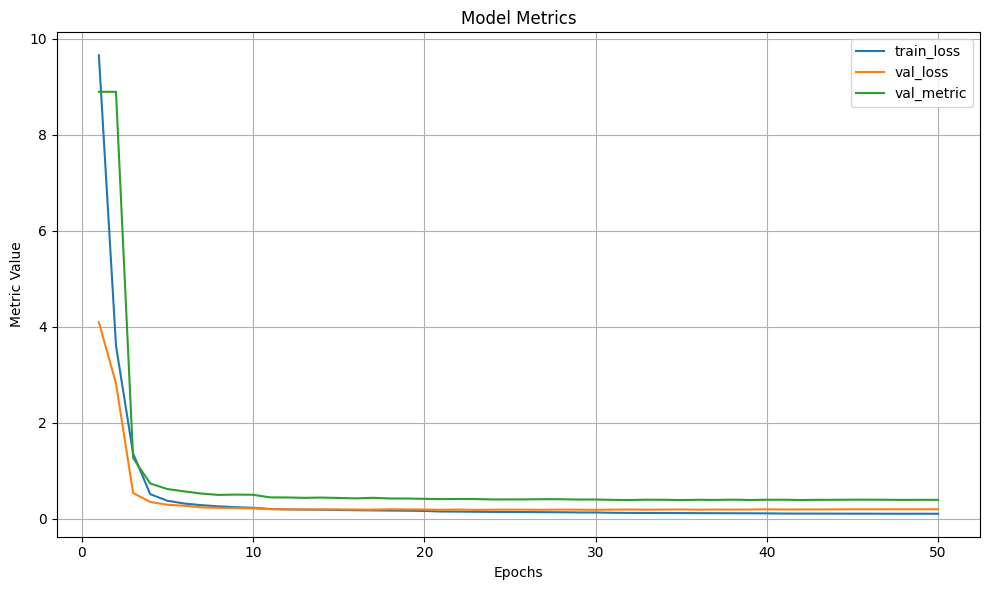

In [74]:
plot_metrics(cnn_blackmel_metrics)

In [76]:
def model_predict(
    model: nn.Module,
    test_paths: pd.Series,
    tokenizer: Tokenizer,
    decoder: Callable,
    batch_size: int = 32,
    device: Optional[torch.device] = None,
) -> pd.DataFrame:
    """
    Parameters:
        model (nn.Module): Обученная модель для предсказаний.
        test_paths (pd.Series): Имена тестовых аудиофайлов.
        tokenizer (Tokenizer): Tokenizer для декодирования индексов.
        decoder(Callable): Декодер для преобразования выходов модели в индексы словаря.
        batch_size (int): Размер батча для DataLoader.
        device (torch.device): Устройство (CPU или CUDA), на котором будет происходить вычисление.

    Returns:
        pd.DataFrame: DataFrame с декодированными предсказаниями.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    test_dataset = MorseDataset(
        X_filenames=test_paths, transform=transform, tokenizer=tokenizer
    )

    test_loader = data_loader(
        test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=4
    )

    predictions = []

    with torch.no_grad():
        with tqdm(test_loader, desc="Predicting", total=len(test_loader)) as pbar:
            for batch in pbar:
                inputs = batch["input"].to(device)  # [B, C, T]

                outputs = model(inputs)
                emissions = outputs.detach().cpu().float()
                decoded_preds = decoding_to_tokens(decoder, emissions, tokenizer)

                predictions.extend(decoded_preds)

                pbar.set_postfix({"Predictions": len(predictions)})

    return pd.DataFrame({"id": test_paths, "message": predictions})

In [77]:
res = model_predict(model=cnn_blackmel_model, test_paths=test_df['id'],tokenizer=tokenizer, decoder=beam_search_decoder,batch_size=128)

Predicting: 100%|██████████| 40/40 [00:27<00:00,  1.44it/s, Predictions=5000]


In [78]:
res = res.set_index("id")
res.to_csv('submission.csv')

In [79]:
def replace_opus_with_wav(csv_path, output_path=None):
    df = pd.read_csv(csv_path)
    df['id'] = df['id'].str.replace('.wav', '.opus', regex=False)

    if output_path is None:
        output_path = csv_path  

    df.to_csv(output_path, index=False, encoding='utf-8')
    
replace_opus_with_wav("submission.csv")

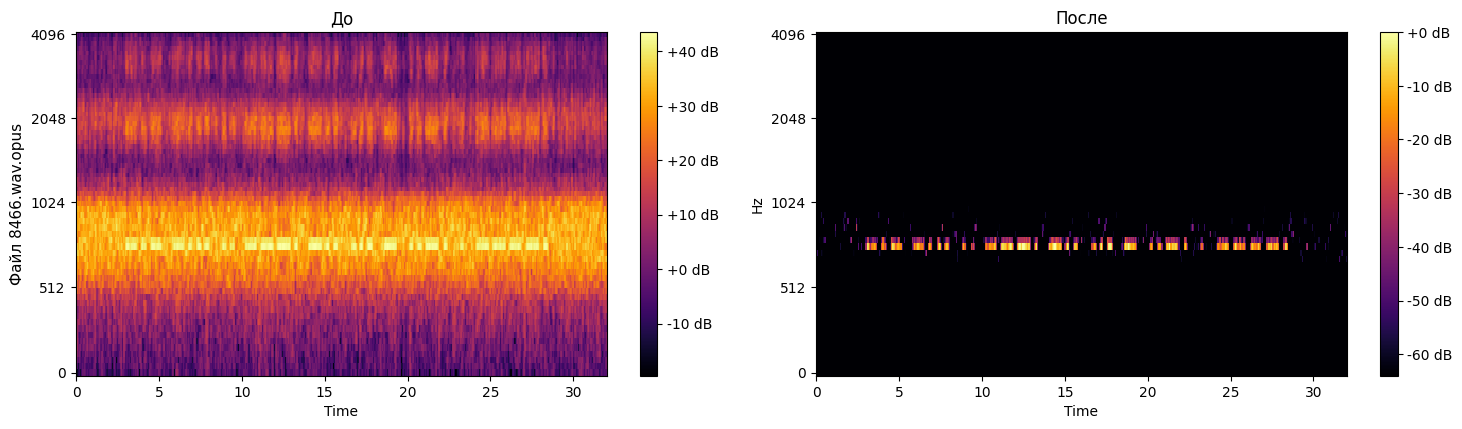

In [117]:
import librosa
import librosa.display as ld
import pywt

np.random.seed(15)
sample = np.random.randint(low=0, high=30000, size=1)
sample_train = train_df['id'][sample]
cmap = "inferno"

plt.figure(figsize=(15, 12))

for i, file_id in enumerate(sample_train):
    waveform, sr = torchaudio.load(AUDIO_FILES_DIR / file_id)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=512, hop_length=128, n_mels=64, f_max=4096
    )(waveform)

    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=64)(mel).squeeze(0)

    boost_mel = mel**8
    
    boost_mel = boost_mel / boost_mel.max()
    boost_mel_db = torchaudio.transforms.AmplitudeToDB(top_db=64)(boost_mel).squeeze(0)
   

    plt.subplot(3, 2, 2 * i + 1)
    ld.specshow(
        mel_db.numpy(), sr=sr, x_axis="time", y_axis="mel", fmax=4096, cmap=cmap
    )
    if i == 0:
        plt.title("До")

    plt.colorbar(format="%+2.0f dB")
    plt.ylabel(f"Файл {file_id}.opus", fontsize=11)

    plt.subplot(3, 2, 2 * i + 2)
    ld.specshow(
        boost_mel_db.numpy(), sr=sr, x_axis="time", y_axis="mel", fmax=4096, cmap=cmap
    )
    if i == 0:
        plt.title("После")
    plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()